In [104]:
import baostock as bs
import pandas as pd
import mplfinance as mpf
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
from datetime import datetime
import numpy as np
import os
from dtw import *
from sklearn.preprocessing import MinMaxScaler

In [123]:
year = '2000'
n_clusters = 60
batch_size = 1000
k_means_dir = rf'G:/app/backup/data/k_means/5-2/{n_clusters}-{batch_size}/{year}/'
model_path = os.path.join(k_means_dir, f"cluster_model_{n_clusters}_all.joblib")

In [115]:
lg = bs.login()

login success!


In [120]:
rs = bs.query_history_k_data_plus("sh.601318", "time,open,high,low,close,volume,amount", start_date='2024-03-12',
                                  end_date='2024-03-12', frequency="5", adjustflag="2")
data_list = []
while (rs.error_code == '0') & rs.next():
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)

In [121]:
result['time'] = result['time'].apply(lambda x: x[:14])
result['time'] = result['time'].apply(
    lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8] + ' ' + x[8:10] + ':' + x[10:12] + ':' + x[12:14])
result['time'] = pd.to_datetime(result['time'], format='%Y-%m-%d %H:%M:%S')
result.set_index('time', inplace=True)
result['open'] = pd.to_numeric(result['open'])
result['close'] = pd.to_numeric(result['close'])
result['high'] = pd.to_numeric(result['high'])
result['low'] = pd.to_numeric(result['low'])
result['volume'] = pd.to_numeric(result['volume'])

In [125]:
model = load(model_path)
scaler = MinMaxScaler()
s = scaler.fit_transform(np.vstack(model.cluster_centers_))

In [165]:
first = 47
center_dist = []
for i, center in enumerate(model.cluster_centers_):
    alignment = dtw(center[:first], result[['open', 'high', 'low', 'close']].values[:first], keep_internals=True)
    center_dist.append((i, alignment.distance, center))
center_dist = sorted(center_dist, key=lambda x: x[1])

C:\Users\xiche\anaconda3\envs\capital-features-learning\lib\site-packages\mplfinance\plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)


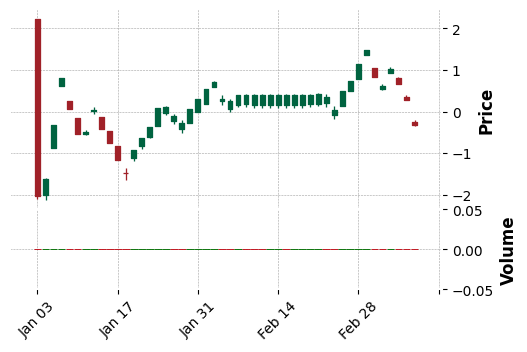

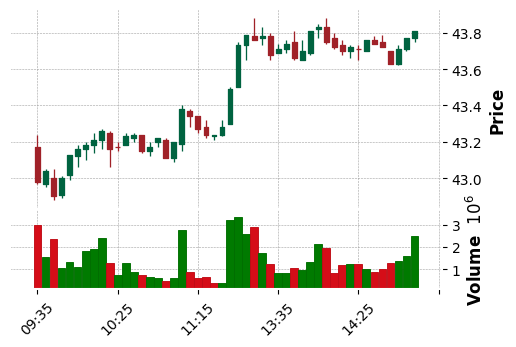

In [169]:
df = pd.DataFrame(center_dist[20][2], columns=['open', 'high', 'low', 'close'])
df['Date'] = pd.date_range(start='1/1/2000', periods=48, freq='B')
df['volume'] = 0
df = df.set_index('Date')
mpf.plot(df, type='candle', style='charles', volume=True, figsize=(6, 4))
mpf.plot(result, type='candle', style='charles', volume=True, figsize=(6, 4))

In [170]:
bs.logout()

logout failed!
